# Setup

**Libraries:**

In [1]:
%%capture
!pip install --upgrade pypair

In [2]:
import gc
gc.enable()

import warnings
warnings.filterwarnings(category=FutureWarning, action='ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pypair.association import binary_continuous, binary_binary
from sklearn.feature_selection import (
    chi2, 
    f_classif, 
    mutual_info_classif
)
from sklearn.ensemble import ExtraTreesClassifier

**Data:**

In [3]:
data = pd.read_csv('/kaggle/input/predict-online-course-engagement-dataset/online_course_engagement_data.csv')

# Data overview

Description of columns:
* UserID: Unique identifier for each user
* CourseCategory: Category of the course taken by the user (e.g., Programming, Business, Arts)
* TimeSpentOnCourse: Total time spent by the user on the course in hours
* NumberOfVideosWatched: Total number of videos watched by the user
* NumberOfQuizzesTaken: Total number of quizzes taken by the user
* QuizScores: Average scores achieved by the user in quizzes (percentage)
* CompletionRate: Percentage of course content completed by the user
* DeviceType: Type of device used by the user (Device Type: Desktop (0) or Mobile (1))
* CourseCompletion (Target Variable): Course completion status (0: Not Completed, 1: Completed)


In [4]:
data.sample()

,UserID,CourseCategory,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate,DeviceType,CourseCompletion
7791,8123,Arts,78.774577,0,3,70.116817,37.963413,1,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UserID                 9000 non-null   int64  
 1   CourseCategory         9000 non-null   object 
 2   TimeSpentOnCourse      9000 non-null   float64
 3   NumberOfVideosWatched  9000 non-null   int64  
 4   NumberOfQuizzesTaken   9000 non-null   int64  
 5   QuizScores             9000 non-null   float64
 6   CompletionRate         9000 non-null   float64
 7   DeviceType             9000 non-null   int64  
 8   CourseCompletion       9000 non-null   int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 632.9+ KB


**Missing values:**

In [6]:
data.isna().sum().sum()

0

**Duplicates:**

In [7]:
data.duplicated().sum()

877

In [8]:
data.loc[data.duplicated(keep=False)].sort_values(by='UserID')

,UserID,CourseCategory,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate,DeviceType,CourseCompletion
383,17,Science,60.902054,4,10,82.143128,48.550331,1,0
365,17,Science,60.902054,4,10,82.143128,48.550331,1,0
4418,68,Business,82.123358,4,9,52.816484,74.957420,1,0
7350,68,Business,82.123358,4,9,52.816484,74.957420,1,0
7597,70,Science,12.856237,5,9,70.433589,47.756361,1,0
...,...,...,...,...,...,...,...,...,...
6647,8991,Arts,39.429919,15,6,73.535229,70.685044,1,0
4151,8996,Arts,44.522106,13,1,89.044177,35.752738,0,0
716,8996,Arts,44.522106,13,1,89.044177,35.752738,0,0
4375,9000,Health,85.291213,15,4,84.251390,72.540258,0,0


In [9]:
data = data.drop_duplicates(ignore_index=True)

In [10]:
data.shape

(8123, 9)

**Target variable:**

In [11]:
TARGET = 'CourseCompletion'
data[TARGET].value_counts(normalize=True)

CourseCompletion
0    0.560753
1    0.439247
Name: proportion, dtype: float64

Fairly balanced target distribution.  
Model parameters can handle the imbalance; no need for resampling. 

**Number of unique values (feature types):**

In [12]:
data.nunique()

UserID                   8123
CourseCategory              5
TimeSpentOnCourse        8123
NumberOfVideosWatched      21
NumberOfQuizzesTaken       11
QuizScores               8123
CompletionRate           8123
DeviceType                  2
CourseCompletion            2
dtype: int64

In [13]:
features = [f for f in data.columns if f not in ('UserID', TARGET)]
categorical_features = ['CourseCategory', 'DeviceType']
numerical_features = [f for f in features if f not in categorical_features]

In [14]:
data[categorical_features] = data[categorical_features].astype('category')

**Data summary:**

In [15]:
data[numerical_features].describe()

,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate
count,8123.000000,8123.000000,8123.000000,8123.000000,8123.000000
mean,50.607728,10.148098,5.166933,75.091084,51.190873
std,28.364184,5.987972,3.132108,14.339876,29.069716
min,1.005230,0.000000,0.000000,50.005119,0.009327
25%,26.114631,5.000000,2.000000,62.791226,26.276765
50%,50.316921,10.000000,5.000000,75.273913,51.581186
75%,75.377730,15.000000,8.000000,87.497542,76.729629
max,99.992558,20.000000,10.000000,99.994984,99.979711


In [16]:
data[categorical_features].describe()

,CourseCategory,DeviceType
count,8123,8123
unique,5,2
top,Business,1
freq,1657,4065


# Feature exploration + engineering

## Univariate analysis

### CourseCategory

In [17]:
f = 'CourseCategory'

In [18]:
data[f].value_counts(normalize=True)

CourseCategory
Business       0.203989
Health         0.201157
Programming    0.201034
Science        0.200542
Arts           0.193278
Name: proportion, dtype: float64

Balanced categories.

In [19]:
data.groupby(f)[TARGET].value_counts(normalize=True)

CourseCategory  CourseCompletion
Arts            0                   0.554777
                1                   0.445223
Business        0                   0.557634
                1                   0.442366
Health          0                   0.577111
                1                   0.422889
Programming     0                   0.549908
                1                   0.450092
Science         0                   0.564150
                1                   0.435850
Name: proportion, dtype: float64

No ordinal relation based on target splits.  
This feature can be one-hot encoded.

In [20]:
data = pd.get_dummies(data, columns=['CourseCategory'])

### DeviceType

In [21]:
f = 'DeviceType'

In [22]:
data[f].value_counts(normalize=True)

DeviceType
1    0.500431
0    0.499569
Name: proportion, dtype: float64

In [23]:
data.groupby(f)[TARGET].value_counts(normalize=True)

DeviceType  CourseCompletion
0           0                   0.565057
            1                   0.434943
1           0                   0.556458
            1                   0.443542
Name: proportion, dtype: float64

Again, balanced categories and no ordinal split.

### TimeSpentOnCourse

In [24]:
f = 'TimeSpentOnCourse'

In [25]:
def plot_numerical(f):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
    plt.suptitle(f'{f}')
    plt.minorticks_on()
    ax[0].set_title(f"Distribution")
    sns.kdeplot(x=f, data=data, cut=0, ax=ax[0])
    ax[1].set_title(f"Distribution split by target")
    sns.kdeplot(x=f, data=data, hue=TARGET, cut=0, ax=ax[1])
    plt.tight_layout()
    plt.show()

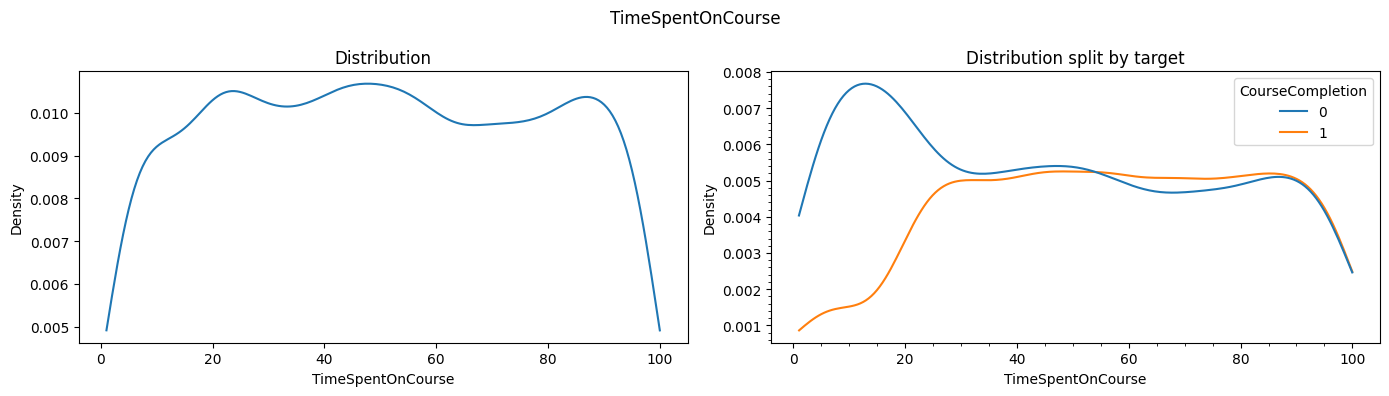

In [26]:
plot_numerical(f)

Beyond a certain amount of time spent on the course, there is no difference in CourseCompletion status.  
However, for low amount of time spent, there is a clear disparity.

In [27]:
data['time_spent_above_threshold'] = (data[f] > 20).astype('category')

In [28]:
data.groupby('time_spent_above_threshold')[TARGET].value_counts(normalize=True)

time_spent_above_threshold  CourseCompletion
False                       0                   0.844700
                            1                   0.155300
True                        1                   0.502559
                            0                   0.497441
Name: proportion, dtype: float64

### NumberOfVideosWatched

In [29]:
f = 'NumberOfVideosWatched'

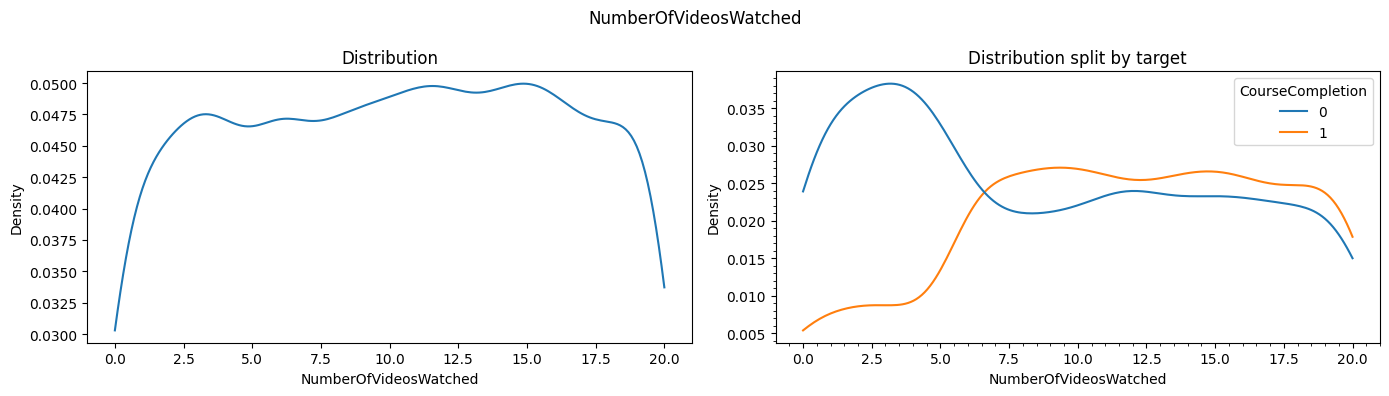

In [30]:
plot_numerical(f)

In [31]:
data['num_videos_above_threshold'] = (data[f] > 5).astype('category')

In [32]:
data['num_videos_above_threshold'].value_counts(normalize=True)

num_videos_above_threshold
True     0.728179
False    0.271821
Name: proportion, dtype: float64

In [33]:
data.groupby('num_videos_above_threshold')[TARGET].value_counts(normalize=True)

num_videos_above_threshold  CourseCompletion
False                       0                   0.821558
                            1                   0.178442
True                        1                   0.536602
                            0                   0.463398
Name: proportion, dtype: float64

### NumberOfQuizzesTaken

In [34]:
f = 'NumberOfQuizzesTaken'

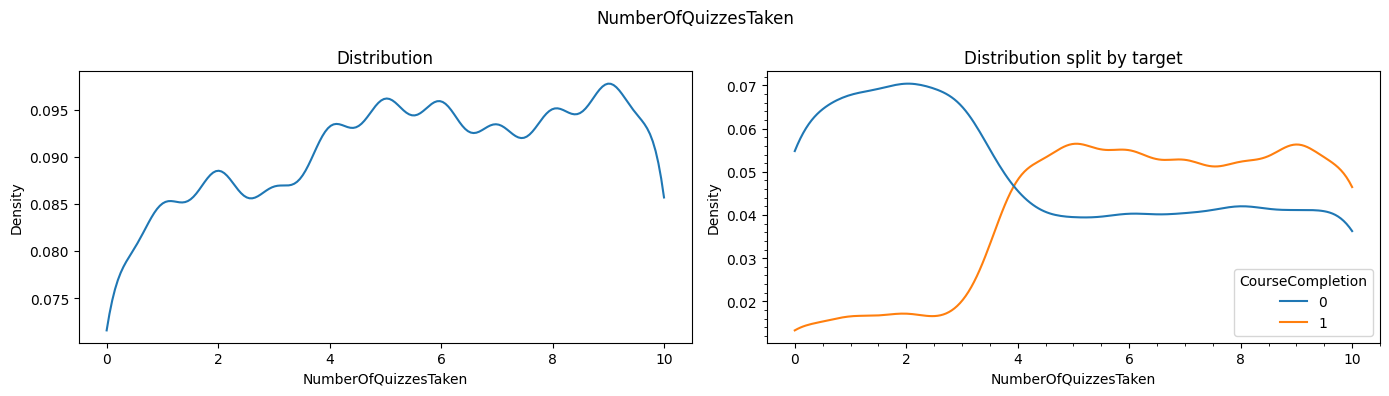

In [35]:
plot_numerical(f)

In [36]:
data['num_quizzes_above_threshold'] = (data[f] > 3).astype('category')

In [37]:
data['num_quizzes_above_threshold'].value_counts(normalize=True)

num_quizzes_above_threshold
True     0.662932
False    0.337068
Name: proportion, dtype: float64

In [38]:
data.groupby('num_quizzes_above_threshold')[TARGET].value_counts(normalize=True)

num_quizzes_above_threshold  CourseCompletion
False                        0                   0.810811
                             1                   0.189189
True                         1                   0.566388
                             0                   0.433612
Name: proportion, dtype: float64

### QuizScores

In [39]:
f = 'QuizScores'

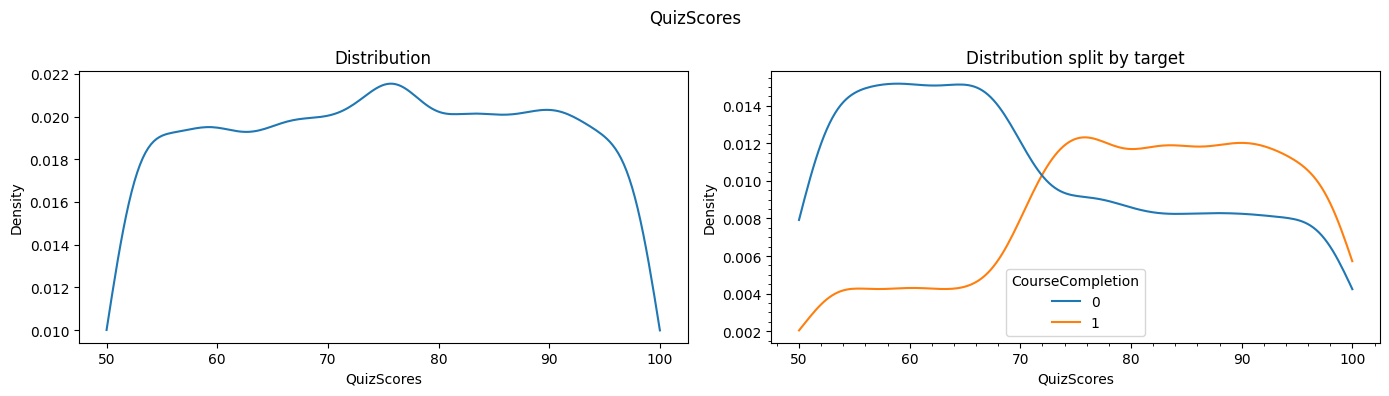

In [40]:
plot_numerical(f)

In [41]:
data['quiz_scores_above_threshold'] = (data[f] > 68).astype('category')

In [42]:
data['quiz_scores_above_threshold'].value_counts(normalize=True)

quiz_scores_above_threshold
True     0.646928
False    0.353072
Name: proportion, dtype: float64

In [43]:
data.groupby('quiz_scores_above_threshold')[TARGET].value_counts(normalize=True)

quiz_scores_above_threshold  CourseCompletion
False                        0                   0.782078
                             1                   0.217922
True                         1                   0.560038
                             0                   0.439962
Name: proportion, dtype: float64

### CompletionRate

In [44]:
f = 'CompletionRate'

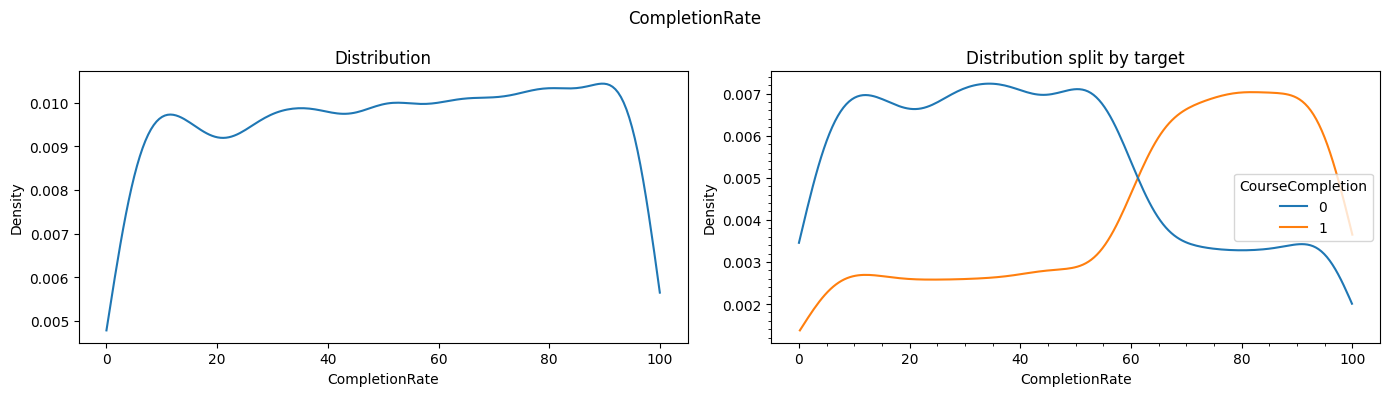

In [45]:
plot_numerical(f)

In [46]:
data['completion_above_threshold'] = (data[f] > 60).astype('category')

In [47]:
data['completion_above_threshold'].value_counts(normalize=True)

completion_above_threshold
False    0.580327
True     0.419673
Name: proportion, dtype: float64

In [48]:
data.groupby('completion_above_threshold')[TARGET].value_counts(normalize=True)

completion_above_threshold  CourseCompletion
False                       0                   0.725499
                            1                   0.274501
True                        1                   0.667058
                            0                   0.332942
Name: proportion, dtype: float64

## Bivariate analysis

### Pairplots

<Figure size 1400x900 with 0 Axes>

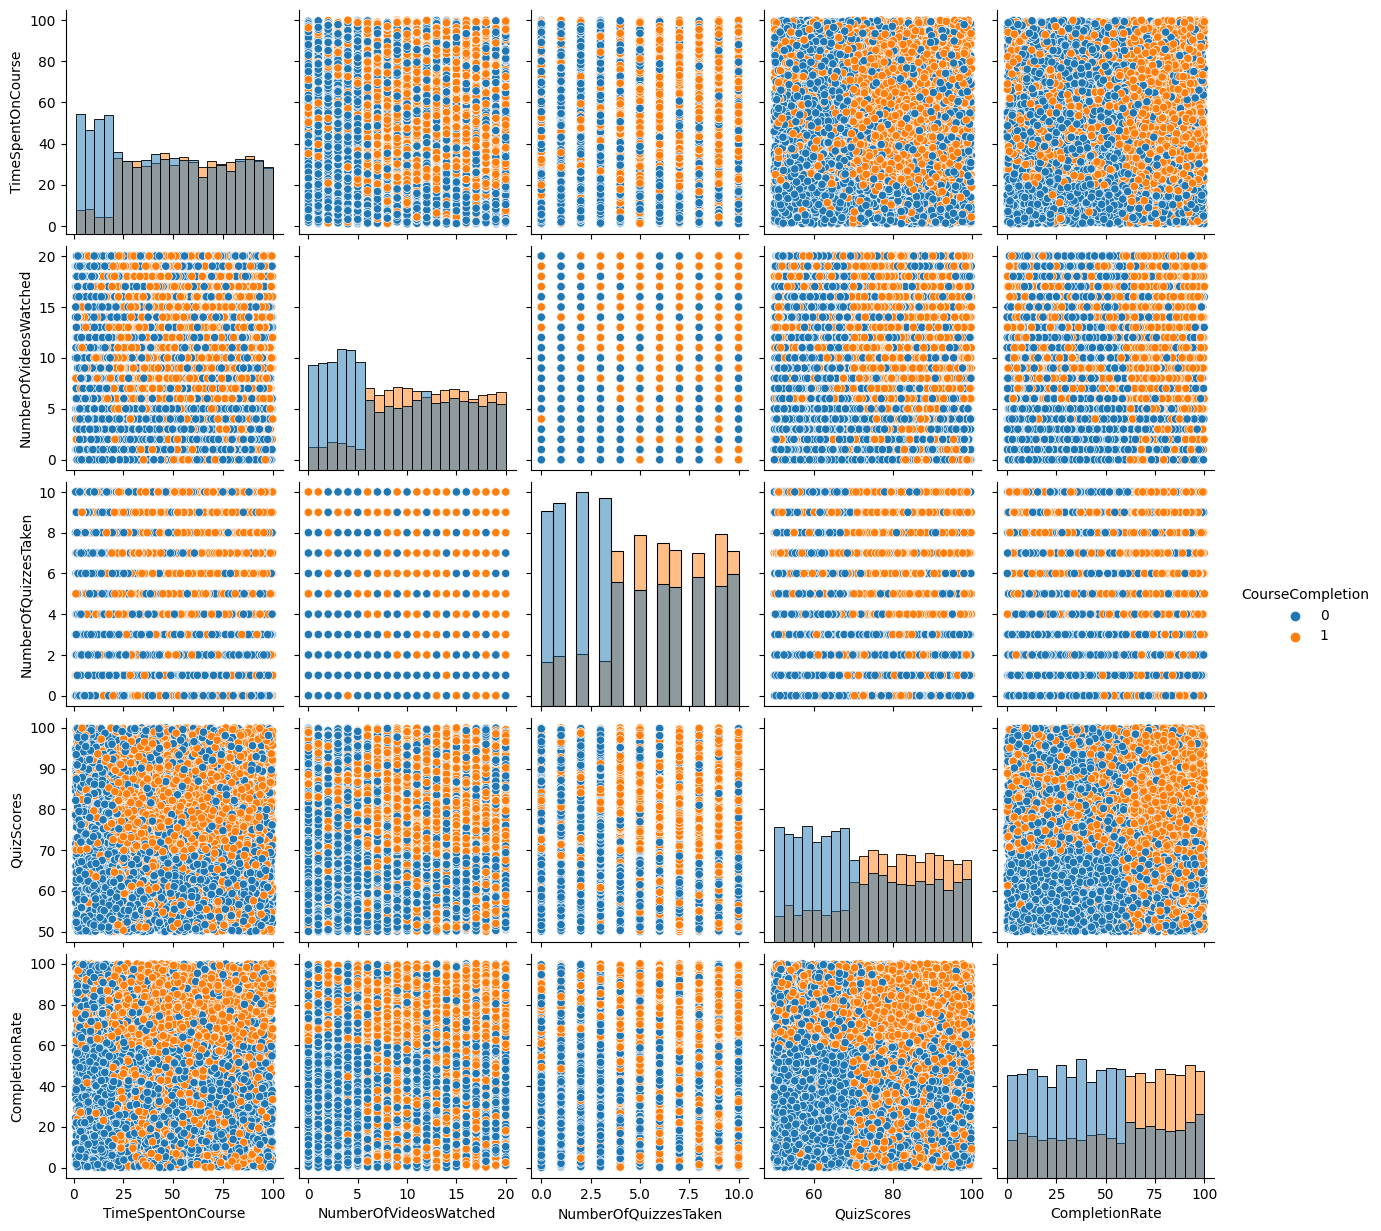

In [49]:
plt.figure(figsize=(14, 9))
sns.pairplot(data=data, kind='scatter', diag_kind='hist', vars=numerical_features, hue=TARGET)
plt.show()

### Pearson correlation (continuous features)

In [50]:
def plot_heatmap(df, size=4):
    plt.figure(figsize=(size, size * 0.75))
    sns.heatmap(
        data=df, 
        mask=np.triu(np.ones_like(df)),
        vmin=-1, vmax=1, center=0,
        annot=True, linewidths=0.1,
        fmt='.2f', annot_kws={'fontsize': 8})
    plt.show()

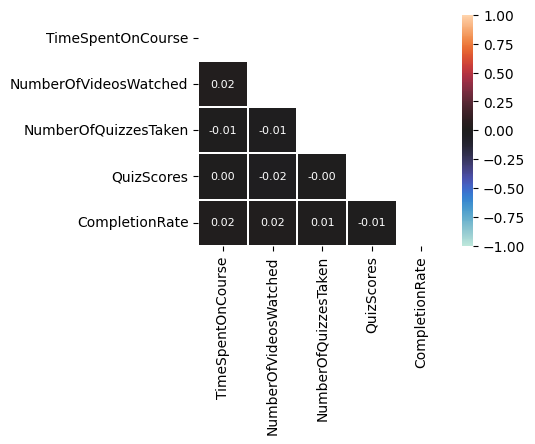

In [51]:
pearson_df = data[numerical_features].corr(method='pearson')
plot_heatmap(pearson_df)

Very low correlations.

### Point Biserial correlation (binary-categorical vs continuous features)

(Reliable for natural binary features. Not for those created based on thresholds)

In [52]:
binary_features = ['DeviceType'] + [f for f in data.columns if f.startswith('CourseCategory')]

In [53]:
pbsr_dict = {}
for bf in binary_features:
    pbsr = [binary_continuous(data[bf], data[nf], measure='point_biserial')
            for nf in numerical_features]
    pbsr_dict[bf] = pbsr

In [54]:
pbsr_df = pd.DataFrame.from_dict(pbsr_dict, orient='index', columns=numerical_features)
pbsr_df

,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate
DeviceType,0.006142,0.006578,0.021572,0.002993,-0.010567
CourseCategory_Arts,-0.006576,0.002472,-0.008768,-0.000887,-0.008592
CourseCategory_Business,-0.002454,-0.007622,0.005793,0.011839,0.011573
CourseCategory_Health,0.007973,-0.008821,0.005219,0.016595,0.009499
CourseCategory_Programming,0.011725,0.024836,-0.001432,-0.011070,-0.001785
CourseCategory_Science,-0.010763,-0.010796,-0.000975,-0.016573,-0.010897


Very low correlations.

### Tetrachoric correlation (binary-categorical features)

In [55]:
binary_features = binary_features + [f for f in data.columns if f.endswith('threshold')]

In [56]:
tetra_dict = {}
for cf1 in binary_features:
    corr = [binary_binary(data[cf1], data[cf2], measure='tetrachoric')
            for cf2 in binary_features]
    tetra_dict[cf1] = corr

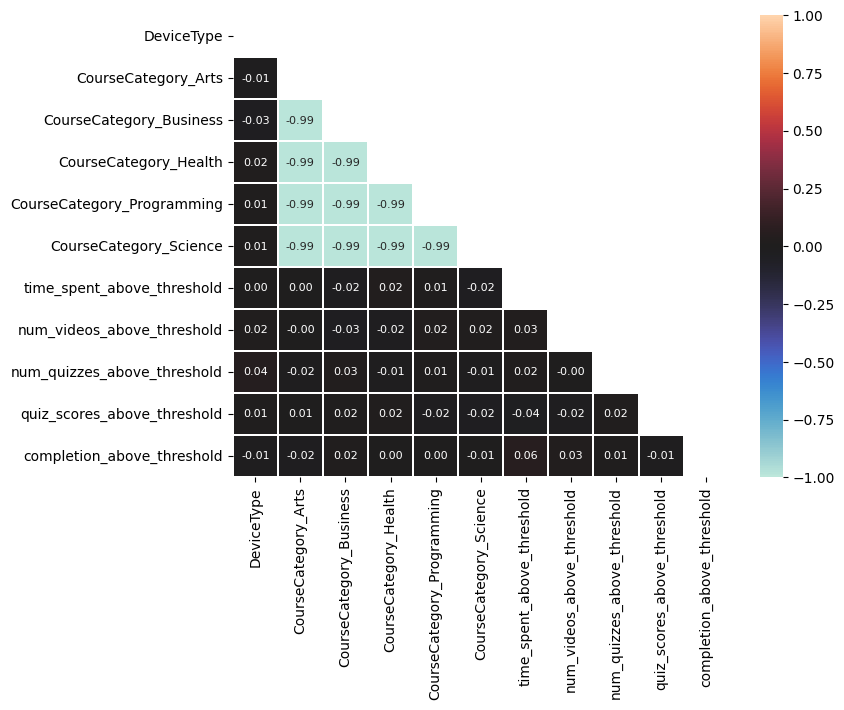

In [57]:
tetra_df = pd.DataFrame.from_dict(tetra_dict, orient='index', columns=binary_features)
plot_heatmap(tetra_df, size=8)

No significant correlations. Only the columns of the one-hot encoded variable have perfect negative correlation with each other.

# Feature selection

In [58]:
def plot_bars(scores, title):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, len(scores)*0.5))
    ax.set_title(title)
    sns.barplot(x=scores.values, y=scores.index, ax=ax)
    for patch in ax.patches:
        y, height, width = patch.get_y(), patch.get_height(), patch.get_width()
        ax.text(width+0.001, y + height/2, f'{width:.4f}', va='center', ha='left', 
                size=8, bbox={'facecolor': 'white', 'boxstyle': 'round'})

### Point-biserial correlation (Binary target vs Continuous features)

In [59]:
pbsr = [binary_continuous(data[TARGET], data[nf], measure='point_biserial')
        for nf in numerical_features]

pbsr = pd.Series(pbsr, index=numerical_features).sort_values(ascending=False)

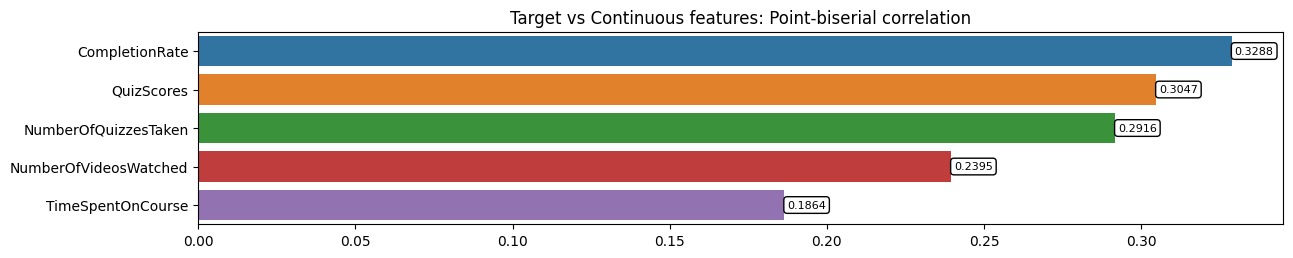

In [60]:
title = 'Target vs Continuous features: Point-biserial correlation'
plot_bars(pbsr, title)

### ANOVA F-test (Categorical target vs Continuous features)

In [61]:
anova_test = f_classif(data[numerical_features], data[TARGET])

In [62]:
pd.DataFrame(
    data={
        'f-statistic': anova_test[0], 
        'p-value': anova_test[1],
        'accepted?': anova_test[1] < 0.05
    },
    index=numerical_features
).sort_values(by='f-statistic')

,f-statistic,p-value,accepted?
TimeSpentOnCourse,292.318484,2.064340e-64,True
NumberOfVideosWatched,494.063836,2.625814e-106,True
NumberOfQuizzesTaken,754.989942,5.209327e-159,True
QuizScores,831.169608,4.239049e-174,True
CompletionRate,984.374219,4.682238e-204,True


### Tetrachoric correlation (Binary target vs Binary features)

In [63]:
tetra = [binary_binary(data[TARGET], data[bf], measure='tetrachoric')
        for bf in binary_features]

tetra = pd.Series(tetra, index=binary_features).sort_values(ascending=False)

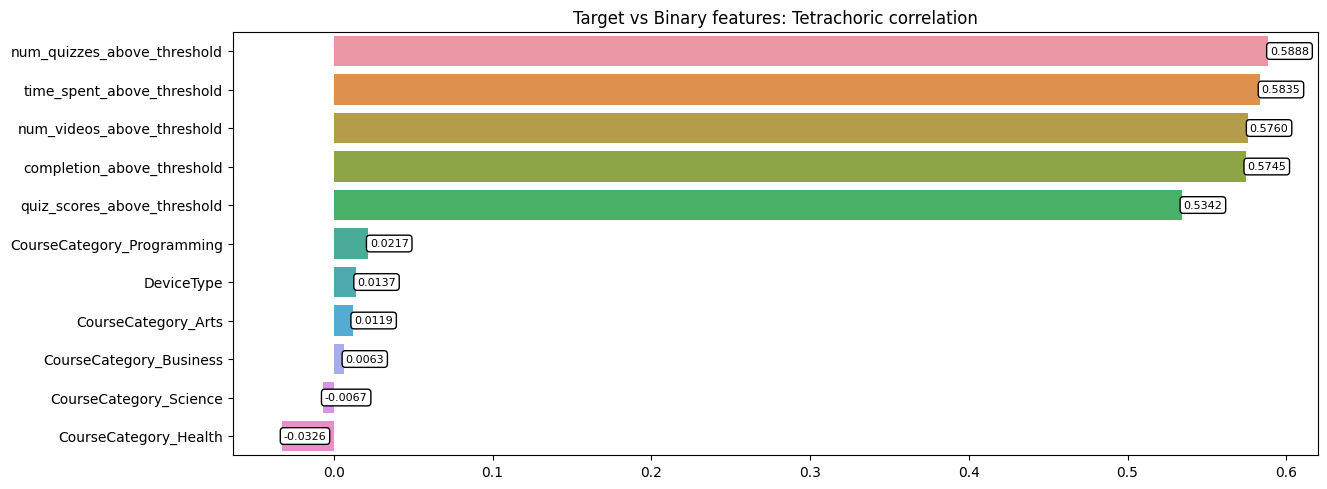

In [64]:
title = 'Target vs Binary features: Tetrachoric correlation'
plot_bars(tetra, title)

### Chi-squared test of independence (Categorical target vs Categorical features)

In [65]:
# all the categorical features are binary (after one-hot encoding)
chi2_test = chi2(data[binary_features], data[TARGET])

In [66]:
pd.DataFrame(
    data={
        'chi2-statistic': chi2_test[0], 
        'p-value': chi2_test[1],
        'accepted?': chi2_test[1] < 0.05
    },
    index=binary_features
).sort_values(by='chi2-statistic')

,chi2-statistic,p-value,accepted?
CourseCategory_Business,0.065450,7.980802e-01,False
CourseCategory_Science,0.076291,7.823888e-01,False
CourseCategory_Arts,0.227662,6.332628e-01,False
DeviceType,0.304564,5.810352e-01,False
CourseCategory_Programming,0.779806,3.772004e-01,False
CourseCategory_Health,1.775131,1.827484e-01,False
time_spent_above_threshold,108.094295,2.562901e-25,True
num_videos_above_threshold,227.611087,1.978501e-51,True
quiz_scores_above_threshold,311.289857,1.143510e-69,True
num_quizzes_above_threshold,353.411163,7.661621e-79,True


* Based on our statistical tests, DeviceType and one-hot encoded CourseCategory are not informative features.
* We can experiment with dropping them from our feature set.

### Mutual information score

In [67]:
features = [f for f in data.columns if f not in ('UserID', TARGET)]

In [68]:
#boolean mask for discrete features
cat_mask = [(f in binary_features) for f in features]

mi_scores = mutual_info_classif(
    data[features], data[TARGET], 
    discrete_features=cat_mask, 
    random_state=0
)

mi_scores = pd.Series(mi_scores, index=features).sort_values(ascending=False)

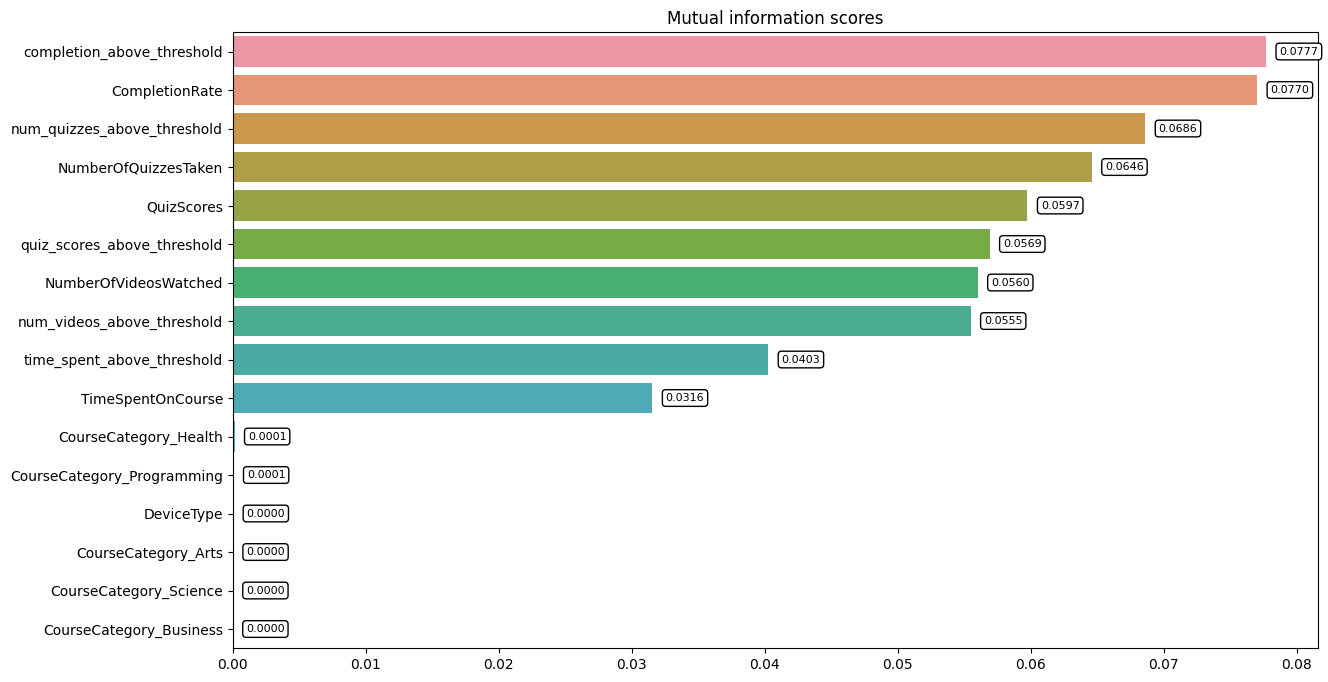

In [69]:
plot_bars(mi_scores, 'Mutual information scores')

### Model-based feature importances
(ExtraTreesClassifier)

**Using all features:**

In [70]:
model = ExtraTreesClassifier(n_estimators=200, max_depth=7, max_features=None, random_state=0)
model.fit(data[features], data[TARGET])

fimp = pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values(ascending=False)

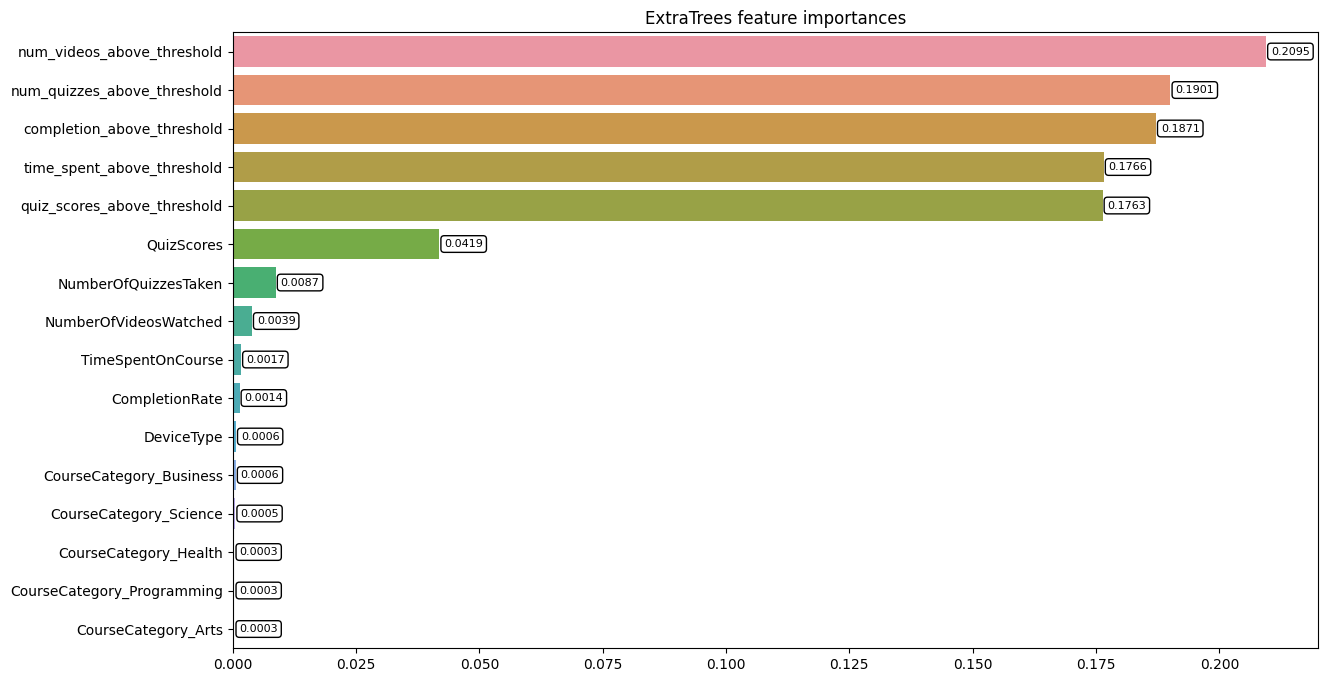

In [71]:
plot_bars(fimp, 'ExtraTrees feature importances')

* Confirms that DeviceType and one-hot encoded CourseCategory are not important features. 
* The numerical features are suppressed here since we already binarized them using ideal thresholds.

**Using original features only:**

In [72]:
original_features = ['DeviceType'] + numerical_features + [f for f in data.columns if f.startswith('CourseCategory')]

model = ExtraTreesClassifier(n_estimators=200, max_depth=7, max_features=None, random_state=0)
model.fit(data[original_features], data[TARGET])

fimp_orig = pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values(ascending=False)

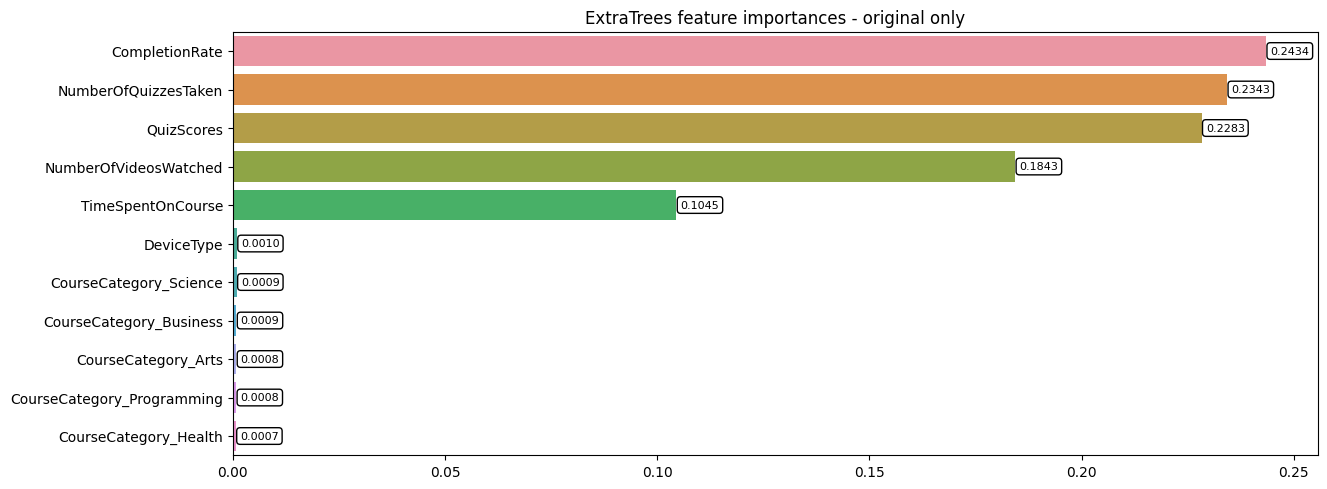

In [73]:
plot_bars(fimp_orig, 'ExtraTrees feature importances - original only')

* After removing the threshold-based features, numerical features regain importance.
* The categorical features are still uninformative. They are prime candidates for removal from our feature set.

# Summary

* 877 completely duplicate rows in the dataset -> directly removed
* Target variable is **fairly balanced**, 56:44 ratio -> No resampling/class-balancing required
* 5 continuous and 2 categorical features
* **Univariate analysis**:
    * Numerical features show significant splits based on target.  
      Binarized based on a trial-and-error threshold using the density distribution.
    * Nominal categorical feature - CourseCategory, showed no ordinal splits. Hence, one-hot encoded.
* **Bivariate analysis**: features had very weak associations based on Point-biserial correlation (binary vs continuous), Pearson correlation (continuous vs continuous) and Tetrachoric correlation (binary vs binary)
* **Feature selection**: 
    * Threshold-based binary features are the most informative.
    * Based on statistical tests, all 5 numerical features are informative (Point-biserial correlation and ANOVA F-test)
    * Based on statistical tests, DeviceType and one-hot encoded CourseCategory are candidates for rejection (Tetrachoric correlation and Chi-squared test of independence)
    * Mutual information scores match the conclusions from type-based statistical tests.
    * Model-based (ExtraTrees) feature importances also confirm the conclusions from all the statistical tests.